Using Athena version 20.7.3.8, on /afs/cern.ch/user/m/mazhang/eos/atlas/user/m/mazhang/Data/xAOD/VertexingXAODttbar/XAOD.pileupTruth.ttbar.pool.root.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
datafile = "../Data/TrackAssociation/20160502.txt"
data = np.loadtxt(datafile, delimiter="\t", skiprows=1) #first row is branch names

In [2]:
branch_names = open(datafile).readline().rstrip().split(",")
branch_names = [c.strip() for c in branch_names]

In [3]:
y = np.array([row[branch_names.index("correctVtx")] for row in data])
X = np.delete(data, branch_names.index("correctVtx"), 1)
branch_names.pop(branch_names.index("correctVtx"));
X = np.delete(X, branch_names.index("truVtxX"), 1)
branch_names.pop(branch_names.index("truVtxX"));
X = np.delete(X, branch_names.index("truVtxY"), 1)
branch_names.pop(branch_names.index("truVtxY"));
X = np.delete(X, branch_names.index("truVtxZ"), 1)
branch_names.pop(branch_names.index("truVtxZ"));

In [4]:
from sklearn import preprocessing
X = preprocessing.scale(X) # center and normalize

In [5]:
from sklearn.cross_validation import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=492)

In [123]:
from sklearn import svm

def train(weight):
    clf = svm.SVC(kernel='rbf', class_weight={0: weight}) # give heavier weights to false tracks
    clf.fit(X_train, y_train)
    return clf

Weight: 1 , Efficiency: 0.988303466037 , Mismatch: 0.10486927787
Weight: 2 , Efficiency: 0.969095396502 , Mismatch: 0.0933641200683
Weight: 3 , Efficiency: 0.937225024144 , Mismatch: 0.0809218141639
Weight: 4 , Efficiency: 0.894838501985 , Mismatch: 0.0687883863763
Weight: 5 , Efficiency: 0.849661980899 , Mismatch: 0.0593965312426


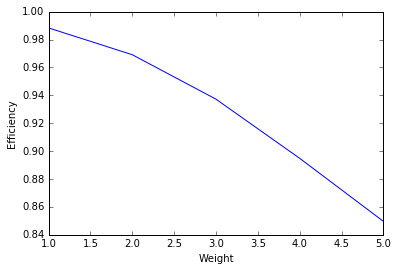

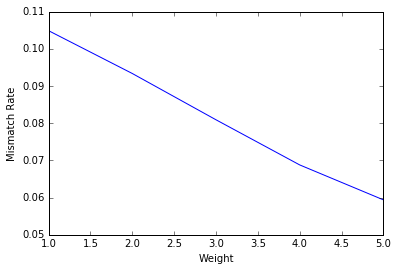

In [124]:
from sklearn.metrics import precision_score, recall_score

weights = np.arange(1, 6, 1)
efficiencies = []
mismatches = []

for weight in weights:

    clf = train(weight)
    y_predicted = np.round(clf.predict(X_val))

    precisionScore = precision_score(y_val, y_predicted)
    recallScore = recall_score(y_val, y_predicted)
    efficiencies.append(recallScore)
    mismatches.append(1-precisionScore)
    print("Weight:", weight, ", Efficiency:", recallScore, ", Mismatch:", 1-precisionScore)
    
plt.plot(weights,efficiencies)
plt.xlabel("Weight")
plt.ylabel("Efficiency")
plt.show()

plt.plot(weights,mismatches)
plt.xlabel("Weight")
plt.ylabel("Mismatch Rate")
plt.show()

In [127]:
def plotMetrics(weight):

    clf = train(weight)
    y_predicted = np.round(clf.predict(X_test))
    
    correctPrediction = 1*np.equal(y_predicted, y_test)
    actualTrue = np.array(y_test==1)
    actualFalse = np.array(y_test==0)
    predictedTrue = np.array(y_predicted==1)
    predictedFalse = np.array(y_predicted==0)

    print("PT = predicted true; AF = actual false")
    print("PT & AT:", sum(np.multiply(predictedTrue, actualTrue)))
    print("PF & AT:", sum(np.multiply(predictedFalse, actualTrue)))
    print("PT & AF:", sum(np.multiply(predictedTrue, actualFalse)))
    print("PF & AF:", sum(np.multiply(predictedFalse, actualFalse)))

    eta = X_test[:,branch_names.index("eta")]
    nbins = 10

    #tracks % identified correctly
    n, _ = np.histogram(eta, bins=nbins)
    sy, _ = np.histogram(eta, bins=nbins, weights=correctPrediction)
    mean = sy / n
    plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
    plt.xlabel("Normalized eta")
    plt.ylabel("Tracks Identified Correctly")
    plt.show()
    print(mean)

    #efficiency = % identified as true out of all actual true
    n, _ = np.histogram(eta[actualTrue], bins=nbins)
    sy, _ = np.histogram(eta[actualTrue], bins=nbins, weights=1*predictedTrue[actualTrue])
    mean = sy / n
    plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
    plt.xlabel("Normalized eta")
    plt.ylabel("Efficiency")
    plt.show()
    print(mean)

    #mismatch rate = % actual false out of those identified as true
    n, _ = np.histogram(eta[predictedTrue], bins=nbins)
    sy, _ = np.histogram(eta[predictedTrue], bins=nbins, weights=1*actualFalse[predictedTrue])
    mean = sy / n
    plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
    plt.xlabel("Normalized eta")
    plt.ylabel("Mismatch Rate")
    plt.show()
    print(mean)

PT = predicted true; AF = actual false
PT & AT: 9183
PF & AT: 116
PT & AF: 1076
PF & AF: 322


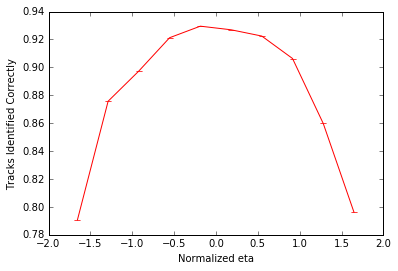

[ 0.79056387  0.8757515   0.89741302  0.92127303  0.92955326  0.92697095
  0.92246696  0.90637945  0.85979381  0.79616307]


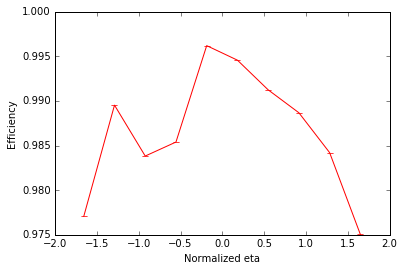

[ 0.97706422  0.9895227   0.98382204  0.98538813  0.99618684  0.99456029
  0.99123661  0.98866856  0.98420413  0.975039  ]


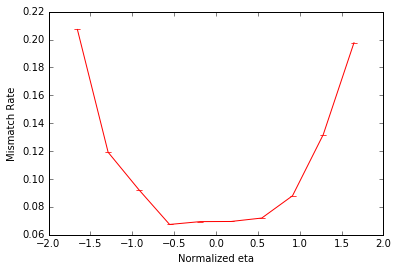

[ 0.20719603  0.11917098  0.09235075  0.06741573  0.06945681  0.06955047
  0.07201459  0.08797909  0.1318328   0.19768935]


In [130]:
plotMetrics(1)

PT = predicted true; AF = actual false
PT & AT: 9029
PF & AT: 270
PT & AF: 935
PF & AF: 463


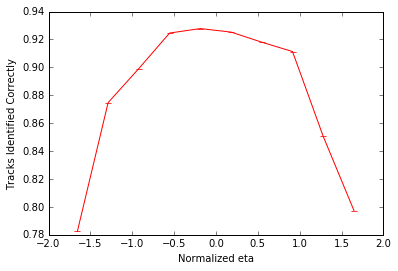

[ 0.78250863  0.8747495   0.89919715  0.92462312  0.92783505  0.9253112
  0.91806167  0.91135046  0.85051546  0.79736211]


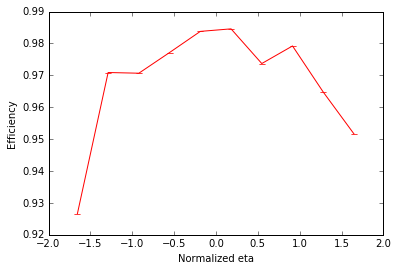

[ 0.9266055   0.97089639  0.97067745  0.97716895  0.98379409  0.98458749
  0.97370983  0.97922568  0.96476306  0.95163807]


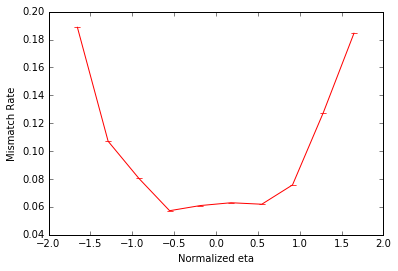

[ 0.18875502  0.10706638  0.08045977  0.05726872  0.06096451  0.06298533
  0.0619137   0.07575758  0.12747253  0.18449198]


In [131]:
plotMetrics(2)

PT = predicted true; AF = actual false
PT & AT: 8733
PF & AT: 566
PT & AF: 753
PF & AF: 645


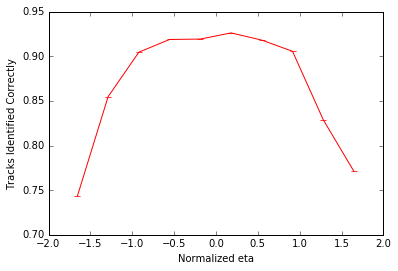

[ 0.7433832   0.85470942  0.90454951  0.91876047  0.91924399  0.92614108
  0.91806167  0.90555095  0.82886598  0.77098321]


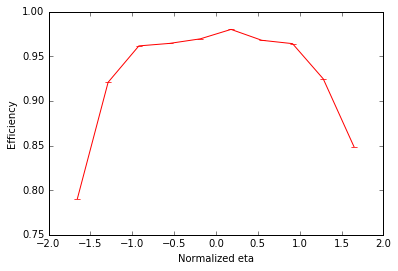

[ 0.79051988  0.92083818  0.96157735  0.96438356  0.96949476  0.9800544
  0.96786758  0.96411709  0.92466586  0.84867395]


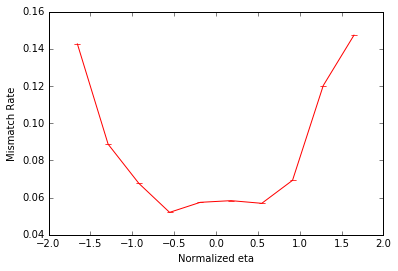

[ 0.14262023  0.08870968  0.06764706  0.05206463  0.05746061  0.05836237
  0.056926    0.06927985  0.12023121  0.14733542]


In [128]:
plotMetrics(3)

PT = predicted true; AF = actual false
PT & AT: 7884
PF & AT: 1415
PT & AF: 482
PF & AF: 916


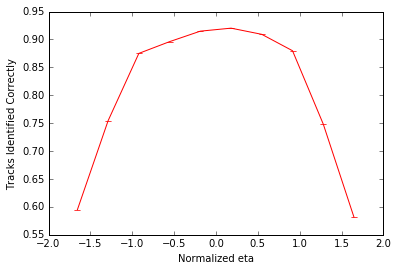

[ 0.59493671  0.75450902  0.87511151  0.8961474   0.91494845  0.92033195
  0.9092511   0.87986744  0.74845361  0.58153477]


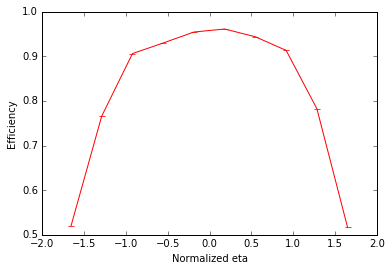

[ 0.51987768  0.76600698  0.90596562  0.92968037  0.95424214  0.96101541
  0.94352483  0.91312559  0.78250304  0.51638066]


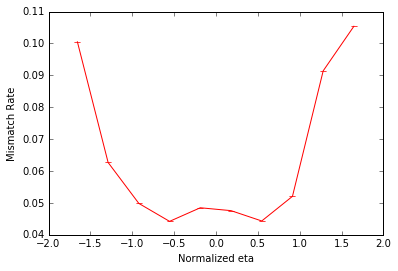

[ 0.1005291   0.06267806  0.04984093  0.04421449  0.04847909  0.0475763
  0.04433498  0.05206287  0.09142053  0.10540541]


In [129]:
plotMetrics(5)